In [8]:
import numpy as np
import pandas as pd
import scipy.stats

pd.options.mode.chained_assignment = None
from matplotlib import pyplot as plt, rcParams
# import cv2
import seaborn as sns

sns.set(style="white", context="paper")
from cycler import cycler
import os, sys
import glob
from datetime import datetime, timedelta
from itertools import combinations, product
import base64
from PIL import Image
from io import BytesIO as _BytesIO
import requests
import json
import pickle
from datetime import datetime
from IPython.display import display, Markdown, Latex
from sklearn.metrics import *
import collections
from copy import deepcopy
import traceback
from sympy import Point, Polygon
from decorators import *
from smartprint import smartprint as sprint
from scipy.spatial.distance import cdist
# import plotly
# from pandas_profiling import ProfileReport

pd.options.display.max_columns = None
def printm(s): return display(Markdown(s))
    
SERVER_CACHE_DIR = '/mnt/ci-nas-cache/edulyzeV2/cache_compute_4/fixed_face'
os.makedirs(SERVER_CACHE_DIR,exist_ok=True)

track_analysis_meta_cache = f'{SERVER_CACHE_DIR}/analysis_tracking/meta_info'
base_dir = '/mnt/ci-nas-cache/edulyzeV2/pose_face_gaze_emb_fixed_face/'

track_analysis_session_data = f'{SERVER_CACHE_DIR}/analysis_tracking/session_tracking_info'
os.makedirs(track_analysis_session_data,exist_ok=True)

postprocessed_id_map_data_dir = f'{SERVER_CACHE_DIR}/analysis_tracking/processed_id_maps'
os.makedirs(postprocessed_id_map_data_dir, exist_ok=True)

emb_analysis_session_data = f'{SERVER_CACHE_DIR}/analysis_emb/session_emb_info_new'
os.makedirs(emb_analysis_session_data,exist_ok=True)

embmatched_id_raw_data_dir = f'{SERVER_CACHE_DIR}/analysis_emb/embmatched_id_raw'
os.makedirs(embmatched_id_raw_data_dir,exist_ok=True)

embmatched_id_map_data_dir = f'{SERVER_CACHE_DIR}/analysis_tracking/embmatched_id_maps'
os.makedirs(embmatched_id_map_data_dir, exist_ok=True)

in_session_median_embeddings_data_dir = f'{SERVER_CACHE_DIR}/analysis_tracking/in_session_median_embeddings'
os.makedirs(in_session_median_embeddings_data_dir, exist_ok=True)

in_session_cluster_embeddings_data_dir = f'{SERVER_CACHE_DIR}/analysis_tracking/in_session_cluster_embeddings'
os.makedirs(in_session_cluster_embeddings_data_dir, exist_ok=True)

id_viz_cache_root = f'{SERVER_CACHE_DIR}/analysis_tracking/session_matching_info'
os.makedirs(id_viz_cache_root, exist_ok=True)

In [9]:
sessionA = 'classinsight-cmu_05748A_ghc_4101_201902141630'
sessionB = 'classinsight-cmu_05748A_ghc_4101_201902281630'
course = '05748A'

In [10]:
sessionA_frame_dir = f'{base_dir}/{course}/{sessionA}-front'
sessionB_frame_dir = f'{base_dir}/{course}/{sessionB}-front'

## Get frame file data for all sessions

In [11]:

frame_file_data = {}
for course_idx, course_dir in enumerate(glob.glob(f"{base_dir}/*")):
    course_name = course_dir.split("/")[-1]
    course_cache_file = f"{track_analysis_meta_cache}/{course_name}"
    if os.path.exists(course_cache_file):
        frame_file_data[course_name] = pickle.load(open(course_cache_file,"rb"))
        continue
    frame_file_data[course_name]={}
        
    for session_idx, session_dir in enumerate(glob.glob(f"{course_dir}/*")):
        session_name = session_dir.split("/")[-1]
        frame_file_data[course_name][session_name] = {}
        frame_files = glob.glob(f"{session_dir}/*")
        frame_file_names = [xr.split("/")[-1] for xr in frame_files]
        if 'end.pb' in frame_file_names:
            frame_file_data[course_name][session_name]['is_completed']=True
        else:
            frame_file_data[course_name][session_name]['is_completed']=False            
        frame_ids = [int(xr.split(".")[0]) for xr in frame_file_names if not (xr=='end.pb')]
        frame_file_data[course_name][session_name]['frame_ids'] = sorted(frame_ids)
        frame_file_data[course_name][session_name]['dir_location'] = session_dir
        print(f"Got metadata for course: {course_idx}-{course_name}, session:{session_idx}-{session_name}")
    pickle.dump(frame_file_data[course_name],open(course_cache_file,"wb")) 
        
frame_file_data.keys()

dict_keys(['05748A', '05410B', '17214C', '17214B', '05681A'])

## Get embedding and gaze information for all frames for all sessions (Run if needed, commented out for now)?

In [12]:
sessionA_emb_info = pickle.load(open(f'{emb_analysis_session_data}/{sessionA}-front.pb','rb'))
sessionB_emb_info = pickle.load(open(f'{emb_analysis_session_data}/{sessionB}-front.pb','rb'))

sessionA_id_map = pickle.load(open(f"{postprocessed_id_map_data_dir}/{sessionA}-front.pb","rb"))
sessionB_id_map = pickle.load(open(f"{postprocessed_id_map_data_dir}/{sessionB}-front.pb","rb"))

df_sessionA_eligible_pairs = pd.read_csv(f"{embmatched_id_map_data_dir}/{sessionA}-front.csv")
df_sessionB_eligible_pairs = pd.read_csv(f"{embmatched_id_map_data_dir}/{sessionB}-front.csv")

sessionA_video_file = f'/mnt/ci-nas-classes/classinsight/2019S/video_backup/{sessionA}/{sessionA}-front.avi'
sessionB_video_file = f'/mnt/ci-nas-classes/classinsight/2019S/video_backup/{sessionB}/{sessionB}-front.avi'

## Replace raw ids with mapped ids after postprocessing for both sessions

In [13]:
sessionA_emb_info = {
    xr:{
        sessionA_id_map[yr]:sessionA_emb_info[xr][yr] 
            for yr in sessionA_emb_info[xr] if not (sessionA_id_map[yr]==10000)} for xr in sessionA_emb_info}

In [14]:
sessionB_emb_info = {
    xr:{
        sessionB_id_map[yr]:sessionB_emb_info[xr][yr] 
            for yr in sessionB_emb_info[xr] if not (sessionB_id_map[yr]==10000)} for xr in sessionB_emb_info}

In [15]:
len(sessionA_emb_info.keys()), len(sessionB_emb_info.keys())

(23913, 22394)

# Correct new ids with dict from eligible pairs

In [16]:
eligible_id_map_dictA = {}
for id_pair in df_sessionA_eligible_pairs.id_pair.values:
    (id1, id2) = eval(id_pair)
    print(id1, id2)
    if id2 in eligible_id_map_dictA:
        eligible_id_map_dictA[id1] = eligible_id_map_dictA[id2]
    else:
        eligible_id_map_dictA[id2] = id1

eligible_id_map_dictB = {}
for id_pair in df_sessionB_eligible_pairs.id_pair.values:
    (id1, id2) = eval(id_pair)
    if id2 in eligible_id_map_dictB:
        eligible_id_map_dictB[id1] = eligible_id_map_dictB[id2]
    else:
        eligible_id_map_dictB[id2] = id1
sprint(eligible_id_map_dictA)
sprint(eligible_id_map_dictB)

2 35
3 32
3 33
12 36
20 26
25 29
Dict: eligible_id_map_dictA
Key: Value


{26: 20, 29: 25, 32: 3, 33: 3, 35: 2, 36: 12}

Dict: eligible_id_map_dictB
Key: Value


{14: 10, 30: 27, 33: 28}

In [17]:
df_sessionA_eligible_pairs

,id_pair,value_overlap,value_match
0,"(2, 35)",0.956510,0.195365
1,"(3, 32)",0.821217,0.160097
2,"(3, 33)",1.000000,0.138525
3,"(12, 36)",0.982976,0.137830
4,"(20, 26)",0.951355,0.113386
5,"(25, 29)",0.947668,0.164082


In [18]:
df_sessionB_eligible_pairs

,id_pair,value_overlap,value_match
0,"(10, 14)",0.977435,0.182358
1,"(27, 30)",0.969473,0.190827
2,"(28, 33)",1.000000,0.113473


In [19]:
eval(df_sessionA_eligible_pairs.id_pair.values[0])

(2, 35)

In [20]:
# arrange info as per tracking id across both sessions
# pitch, roll, yaw= sessionA_emb_info[0][9]['rvec'][0]
gaze_infoA = {}
emb_infoA = {}
bbox_infoA = {}
for frame_number in sessionA_emb_info:
    for trackId_old in sessionA_emb_info[frame_number]:
        trackId = trackId_old if (trackId_old not in eligible_id_map_dictA.keys()) else eligible_id_map_dictA[trackId_old]
        if trackId not in gaze_infoA:
            gaze_infoA[trackId] = []
            emb_infoA[trackId]=[]
            bbox_infoA[trackId] = []
        # get  gaze info
        try:
            id_bbox = sessionA_emb_info[frame_number][trackId]['bbox']
            bbox_infoA[trackId].append([frame_number]+list(id_bbox))
            pitch, roll, yaw= sessionA_emb_info[frame_number][trackId]['rvec'][0]
            pitch, roll, yaw=np.rad2deg(pitch), np.rad2deg(roll), np.rad2deg(yaw)
            gaze_sx, gaze_sy, gaze_ex, gaze_ey = sessionA_emb_info[frame_number][trackId]['gaze_2d'][0].flatten()
            gaze_infoA[trackId].append([frame_number, pitch, roll, yaw, gaze_sx, gaze_sy, gaze_ex, gaze_ey])
            face_emb = sessionA_emb_info[frame_number][trackId]['face_embedding'].tolist()
            emb_infoA[trackId].append([frame_number]+face_emb)
        except:
            continue

for id in gaze_infoA:
    gaze_infoA[id] = pd.DataFrame(gaze_infoA[id], columns=['frame','pitch','roll','yaw','gaze_sx', 'gaze_sy', 'gaze_ex', 'gaze_ey']).set_index('frame')
    emb_infoA[id] =pd.DataFrame(emb_infoA[id], columns=['frame']+np.arange(512).tolist()).set_index('frame')
    bbox_infoA[id] = pd.DataFrame(bbox_infoA[id], columns=['frame']+np.arange(5).tolist()).set_index('frame')

gaze_infoB = {}
emb_infoB = {}
bbox_infoB = {}
for frame_number in sessionB_emb_info:
    for trackId_old in sessionB_emb_info[frame_number]:
        trackId = trackId_old if (trackId_old not in eligible_id_map_dictB.keys()) else eligible_id_map_dictB[trackId_old]
        if trackId not in gaze_infoB:
            gaze_infoB[trackId] = []
            emb_infoB[trackId]=[]
            bbox_infoB[trackId] = []
        # get  gaze info
        try:
            id_bbox = sessionB_emb_info[frame_number][trackId]['bbox']
            bbox_infoB[trackId].append([frame_number]+list(id_bbox))
            pitch, roll, yaw= sessionB_emb_info[frame_number][trackId]['rvec'][0]    
            gaze_sx, gaze_sy, gaze_ex, gaze_ey = sessionB_emb_info[frame_number][trackId]['gaze_2d'][0].flatten()
            pitch, roll, yaw=np.rad2deg(pitch), np.rad2deg(roll), np.rad2deg(yaw)
            gaze_infoB[trackId].append([frame_number, pitch, roll, yaw, gaze_sx, gaze_sy, gaze_ex, gaze_ey])
            face_emb = sessionB_emb_info[frame_number][trackId]['face_embedding'].tolist()
            emb_infoB[trackId].append([frame_number]+face_emb)
        except:
            continue


for id in gaze_infoB:
    gaze_infoB[id] = pd.DataFrame(gaze_infoB[id], columns=['frame','pitch','roll','yaw','gaze_sx', 'gaze_sy', 'gaze_ex', 'gaze_ey']).set_index('frame')
    emb_infoB[id] =pd.DataFrame(emb_infoB[id], columns=['frame']+np.arange(512).tolist()).set_index('frame')
    bbox_infoB[id] = pd.DataFrame(bbox_infoB[id], columns=['frame']+np.arange(5).tolist()).set_index('frame')

len(gaze_infoA.keys()), len(gaze_infoB.keys())

(31, 34)

In [21]:
sprint({xr:(gaze_infoA[xr].shape[0],emb_infoA[xr].shape[0], bbox_infoA[xr].shape[0]) for xr in emb_infoA})

Dict: {xr:(gaze_infoA[xr].shape[0],emb_infoA[xr].shape[0], bbox_infoA[xr].shape[0]) for xr in emb_infoA}
Key: Value


{0: (23858, 23858, 23913),
 1: (23871, 23871, 23904),
 2: (20407, 20407, 20916),
 3: (17711, 17711, 18093),
 4: (23891, 23891, 23911),
 5: (23809, 23809, 23913),
 6: (23497, 23497, 23871),
 7: (17329, 17329, 17409),
 8: (23265, 23265, 23790),
 9: (23314, 23314, 23874),
 10: (18783, 18783, 23628),
 11: (777, 777, 822),
 12: (20240, 20240, 20969),
 13: (65, 65, 331),
 14: (22246, 22246, 22669),
 15: (92, 92, 755),
 16: (14917, 14917, 16278),
 17: (19626, 19626, 22457),
 18: (19901, 19901, 19983),
 19: (100, 100, 431),
 20: (6323, 6323, 6375),
 21: (157, 157, 270),
 22: (455, 455, 580),
 23: (272, 272, 351),
 24: (1484, 1484, 1567),
 25: (1573, 1573, 1776),
 27: (358, 358, 416),
 28: (29, 29, 322),
 30: (97, 97, 342),
 31: (169, 169, 325),
 34: (147, 147, 701)}

In [22]:
sprint({xr:(gaze_infoB[xr].shape[0],emb_infoB[xr].shape[0], bbox_infoB[xr].shape[0]) for xr in emb_infoB})

Dict: {xr:(gaze_infoB[xr].shape[0],emb_infoB[xr].shape[0], bbox_infoB[xr].shape[0]) for xr in emb_infoB}
Key: Value


{0: (22328, 22328, 22394),
 1: (21777, 21777, 22394),
 2: (19868, 19868, 22370),
 3: (22096, 22096, 22383),
 4: (9647, 9647, 9654),
 5: (22380, 22380, 22386),
 6: (21491, 21491, 21682),
 7: (21209, 21209, 22285),
 8: (22194, 22194, 22279),
 9: (21843, 21843, 21880),
 10: (344, 344, 352),
 11: (1623, 1623, 1837),
 12: (17837, 17837, 21536),
 13: (21389, 21389, 21444),
 15: (20502, 20502, 21297),
 16: (20510, 20510, 21266),
 17: (493, 493, 1431),
 18: (19276, 19276, 20938),
 19: (17418, 17418, 19948),
 20: (19020, 19020, 19883),
 21: (7810, 7810, 7832),
 22: (387, 387, 597),
 23: (1125, 1125, 1243),
 24: (383, 383, 1117),
 25: (640, 640, 1020),
 26: (594, 594, 632),
 27: (554, 554, 571),
 28: (3268, 3268, 3268),
 29: (319, 319, 358),
 31: (254, 254, 627),
 32: (699, 699, 911),
 34: (250, 250, 390),
 35: (137, 137, 327),
 36: (395, 395, 583)}

# Ground truth for id matching

In [23]:
sprint(eligible_id_map_dictA)
sprint(eligible_id_map_dictB)

Dict: eligible_id_map_dictA
Key: Value


{26: 20, 29: 25, 32: 3, 33: 3, 35: 2, 36: 12}

Dict: eligible_id_map_dictB
Key: Value


{14: 10, 30: 27, 33: 28}

In [28]:
gt_str_new = '''
3,12
11,17
5,10
5,2
9,9
1,0
6,8
4,8
14,1
16,6
21,4
7,2
0,5
-1,20
13,3
10,7
19,14
19,11
15,-1
2,-1
8,-1
-1,16
-1,18
'''

In [29]:
gt_arr = gt_str.split("\n")[1:-1]
gt_arr = [xr.split(",") for xr in gt_arr]
df_gt = pd.DataFrame(gt_arr, columns=[sessionA,sessionB])
gt_map = df_gt.groupby(sessionA).agg({sessionB:lambda x: list(x)})[sessionB].to_dict()
gt_map

{'-1': ['20', '16', '26', '18'],
 '0': ['5'],
 '1': ['0'],
 '10': ['7'],
 '11': ['17'],
 '13': ['3'],
 '14': ['1'],
 '15': ['-1'],
 '16': ['6'],
 '19': ['14', '11'],
 '2': ['-1'],
 '21': ['4'],
 '24': ['7'],
 '26': ['7'],
 '3': ['12', '36'],
 '30': ['17'],
 '32': ['7'],
 '4': ['8'],
 '5': ['10', '35'],
 '6': ['8'],
 '7': ['2', '35'],
 '8': ['-1'],
 '9': ['9']}

# Clean Implementation 1: Using k% gaze filtering and median embeddings for matching

In [84]:
MAX_GAZE_DEVIATION_DEG = 30
# MAX_EMBEDDING_FRAMES = 1000
MIN_EMBEDDING_FRAMES = 100


In [85]:
match_scores = {}
match_info = {}
np.random.seed(42)
for idA,idB in product(emb_infoA.keys(), emb_infoB.keys()):
    #filter correct frames
    framesA = gaze_infoA[idA][
        (gaze_infoA[idA].yaw.abs()<MAX_GAZE_DEVIATION_DEG) & 
        (gaze_infoA[idA].pitch.abs()<MAX_GAZE_DEVIATION_DEG) & 
        (gaze_infoA[idA].roll.abs()<MAX_GAZE_DEVIATION_DEG)].index.values
    framesB = gaze_infoB[idB][
        (gaze_infoB[idB].yaw.abs()<MAX_GAZE_DEVIATION_DEG) &
        (gaze_infoB[idB].pitch.abs()<MAX_GAZE_DEVIATION_DEG) &
        (gaze_infoB[idB].roll.abs()<MAX_GAZE_DEVIATION_DEG)].index.values

    num_framesA, num_framesB = len(framesA), len(framesB)
    if (num_framesA<MIN_EMBEDDING_FRAMES) | (num_framesB <MIN_EMBEDDING_FRAMES):
        sprint(f"Not sufficient frames to match {idA}:{len(framesA)},{idB}:{len(framesB)}")
        continue
    
    # select_framesA  =  np.random.choice(framesA, MAX_EMBEDDING_FRAMES) if (num_framesA > MAX_EMBEDDING_FRAMES) else  framesA
    # select_framesB  =  np.random.choice(framesB, MAX_EMBEDDING_FRAMES) if (num_framesB > MAX_EMBEDDING_FRAMES) else  framesB

    #get id embeddings
    
    medianA_emb = np.median(emb_infoA[idA].loc[framesA],axis=0)
    medianB_emb = np.median(emb_infoB[idB].loc[framesB],axis=0)
    match_distance = cdist(medianA_emb.reshape(1,-1), medianB_emb.reshape(1,-1))[0][0]
    if idA not in match_scores:
        match_scores[idA] = {}
        match_info[idA] = {}
    match_scores[idA][idB] = match_distance
    match_info[idA][idB] = dict(match_score=match_distance, framesA=framesA, framesB=framesB)
    sprint(idA, idB, match_distance)
    
    
    
    

idA, idB, match_distance : 0 0 0.6659767214030615
idA, idB, match_distance : 0 1 0.34503479725303493
idA, idB, match_distance : 0 2 0.2789774217461603
idA, idB, match_distance : 0 3 0.31156806809543347
idA, idB, match_distance : 0 4 0.2057039190784001
idA, idB, match_distance : 0 5 0.39811592949325014
idA, idB, match_distance : 0 6 0.5236064656143398
idA, idB, match_distance : 0 7 0.6264063790507912
idA, idB, match_distance : 0 8 0.31119206448113484
idA, idB, match_distance : 0 9 0.3969735560858362
idA, idB, match_distance : 0 10 0.5635220192710404
idA, idB, match_distance : 0 11 0.3148624498333488
idA, idB, match_distance : 0 12 0.24855487782917632
idA, idB, match_distance : 0 13 0.4593618098665465
idA, idB, match_distance : 0 15 0.1563210032576205
idA, idB, match_distance : 0 16 0.3140695900959868
f"Not sufficient frames to match {idA}:{len(framesA)},{idB}:{len(framesB)}" : Not sufficient frames to match 0:16370,17:7
idA, idB, match_distance : 0 18 0.41395320146246006
idA, idB, match

In [32]:
df_matching_methodA = pd.DataFrame(match_scores)
df_matching_methodA.shape

(22, 19)

In [33]:
df_matching_methodA

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,19,31
0,0.400317,0.160398,0.467463,0.343354,0.545554,0.564473,0.442918,0.783907,0.287886,0.248193,0.360972,0.310133,0.588749,0.426275,0.470358,0.576870,0.426867,0.507206,0.299797
1,0.372988,0.319910,0.450638,0.373569,0.328838,0.324697,0.299388,0.568561,0.346557,0.394671,0.214885,0.510029,0.410240,0.376545,0.180944,0.358270,0.232551,0.385222,0.310452
2,0.281980,0.552531,0.353664,0.594702,0.333420,0.637804,0.660789,0.290655,0.532777,0.472598,0.411765,0.527057,0.260528,0.311489,0.421416,0.732933,0.538523,0.336619,0.546766
3,0.326588,0.557418,0.339964,0.655529,0.287768,0.665511,0.696894,0.306553,0.563333,0.517920,0.429755,0.597374,0.270000,0.287472,0.410840,0.747072,0.535765,0.392250,0.588852
4,0.209619,0.355958,0.209496,0.532450,0.262397,0.557447,0.520299,0.508391,0.374702,0.356560,0.226272,0.447034,0.272033,0.280836,0.299246,0.596097,0.319652,0.235398,0.387234
5,0.480650,0.687059,0.498502,0.731276,0.332170,0.698447,0.755116,0.159172,0.690462,0.638662,0.512359,0.715066,0.273487,0.461076,0.477320,0.767549,0.616320,0.455902,0.698984
6,0.313949,0.363395,0.324990,0.527418,0.282226,0.474887,0.441360,0.540228,0.388189,0.453559,0.275781,0.550686,0.350237,0.349579,0.244085,0.481239,0.218470,0.335242,0.396804
7,0.351189,0.136211,0.416188,0.294854,0.431075,0.412881,0.281696,0.690286,0.228897,0.258719,0.217291,0.390436,0.487773,0.382241,0.304343,0.436915,0.240267,0.398099,0.178929
8,0.326921,0.253229,0.429889,0.285658,0.465397,0.389303,0.281341,0.657950,0.279553,0.315431,0.312177,0.406919,0.507186,0.366816,0.326982,0.447100,0.300174,0.416873,0.217988
9,0.420094,0.314360,0.474528,0.352975,0.583452,0.623804,0.482944,0.782470,0.311590,0.192321,0.388421,0.244141,0.583601,0.477812,0.537115,0.676657,0.490868,0.464265,0.279651


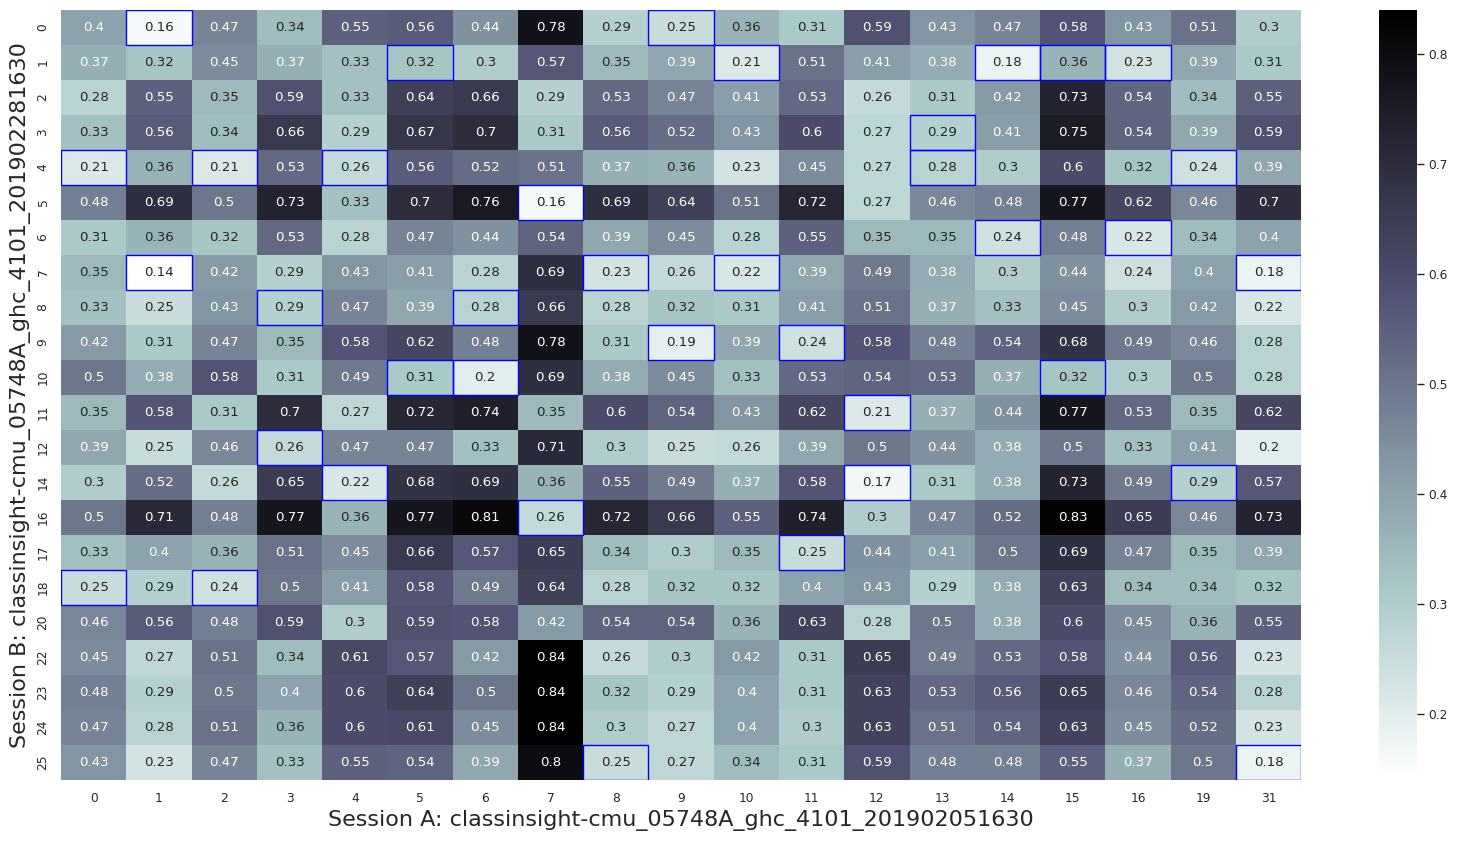

In [70]:
from matplotlib.patches import Rectangle
fig, axn = plt.subplots(1,1,figsize=(20,10))
sns.heatmap(df_matching_methodA.round(2), annot=True,ax=axn,cmap='bone_r')
# for gtA in map(int, gt_map):
#     for gtB in map(int, gt_map[str(gtA)]):
#         if (gtA>=0) and (gtB>=0):
#             if (gtA in df_matching_methodA.columns) and (gtB in df_matching_methodA.index):
#                 locA, locB = df_matching_methodA.columns.get_loc(gtA), df_matching_methodA.index.get_loc(gtB)
#                 axn.add_patch(Rectangle((locA, locB), 1, 1, fill=False, edgecolor='red', lw=4))

for locA in range(df_matching_methodA.shape[1]):
    locBs = df_matching_methodA.iloc[:,locA].argsort()[:2]
    for locB in locBs:
        axn.add_patch(Rectangle((locA, locB), 1, 1, fill=False, edgecolor='blue', lw=1))

# 5, 11, 12, 12 
# absent: 5 out of 20 (how??)
# 
axn.set_xlabel(f"Session A: {sessionA}",fontsize=16)
axn.set_ylabel(f"Session B: {sessionB}",fontsize=16)
plt.savefig(f'plots/Method1_{course}_{sessionA.split("_")[-1]}_{sessionB.split("_")[-1]}.png',dpi=400,bbox_inches='tight')

# Method 2:Get distance between all pairs and get median distance across all pairs. 

In [35]:
MAX_GAZE_DEVIATION_DEG = 30 # for basic filtering of very random gaze
MAX_EMBEDDING_FRAMES = 1000
MIN_EMBEDDING_FRAMES = 100


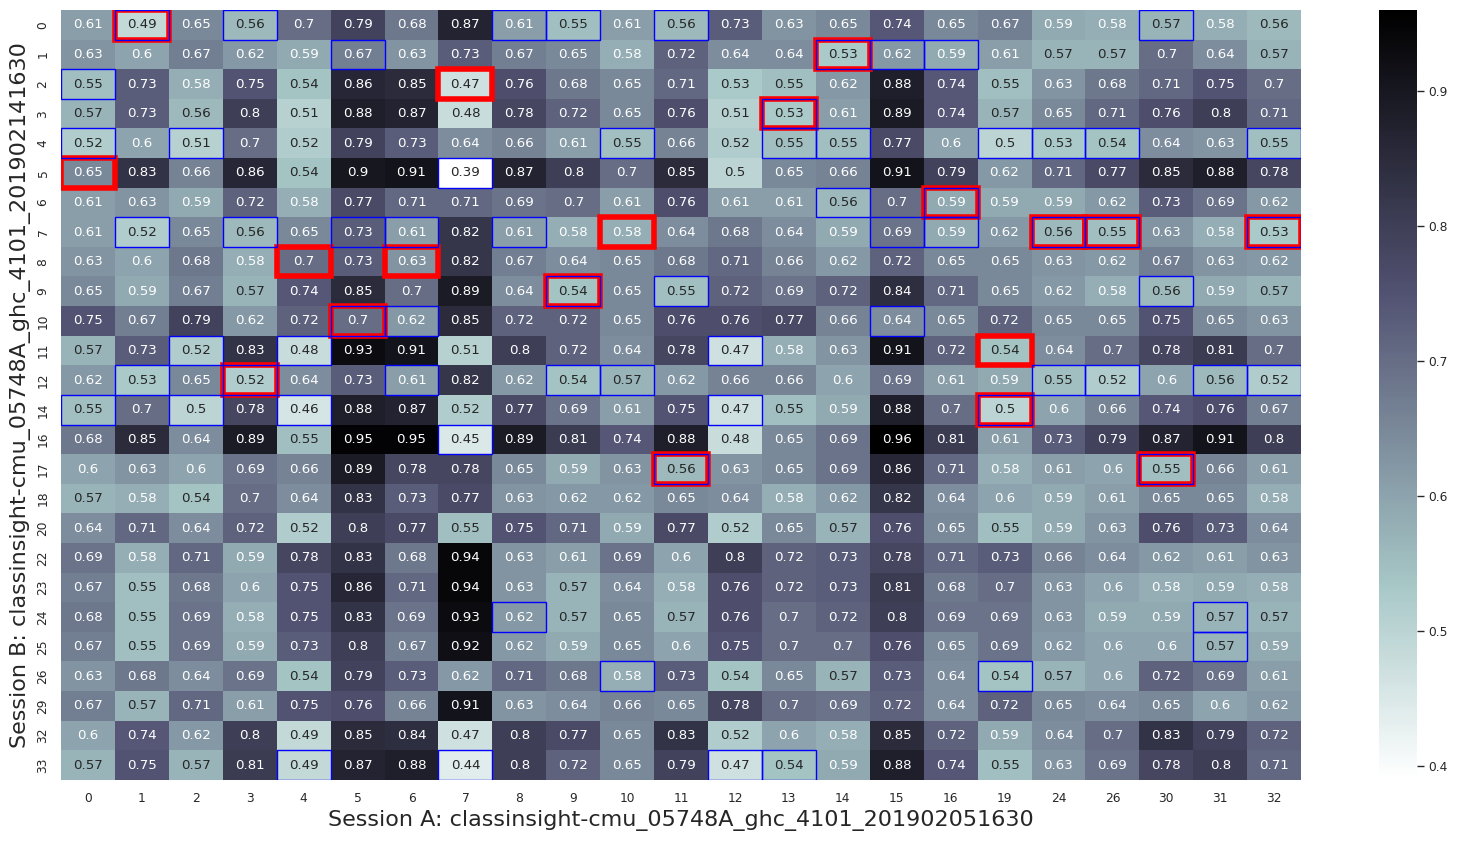

In [198]:
match_scores = {}
for idA in matching_info_dictB:
    match_scores[idA] = {}
    for idB in matching_info_dictB[idA]:
        match_matrix = matching_info_dictB[idA][idB]['match_matrix']
        match_distance = np.median(np.median(match_matrix,axis=1))
        match_scores[idA][idB] = match_distance

df_matching = pd.DataFrame(match_scores)

#--------
fig, axn = plt.subplots(1,1,figsize=(20,10))
sns.heatmap(df_matching.round(2), annot=True,ax=axn,cmap='bone_r')
for gtA in map(int, gt_map):
    for gtB in map(int, gt_map[str(gtA)]):
        if (gtA>=0) and (gtB>=0):
            if (gtA in df_matching.columns) and (gtB in df_matching.index):
                locA, locB = df_matching.columns.get_loc(gtA), df_matching.index.get_loc(gtB)
                axn.add_patch(Rectangle((locA, locB), 1, 1, fill=False, edgecolor='red', lw=4))

for locA in range(df_matching.shape[1]):
    locBs = df_matching.iloc[:,locA].argsort()[:3]
    for locB in locBs:
        axn.add_patch(Rectangle((locA, locB), 1, 1, fill=False, edgecolor='blue', lw=1))


axn.set_xlabel(f"Session A: {sessionA}",fontsize=16)
axn.set_ylabel(f"Session B: {sessionB}",fontsize=16)
plt.savefig(f'plots/Method2b_{course}_{sessionA.split("_")[-1]}_{sessionB.split("_")[-1]}.png',dpi=400,bbox_inches='tight')

# Method 3: Use spectral clustering to get clean set of embeddings, calculate their centroid, and then evaluate distance

In [36]:
from sklearn.cluster import DBSCAN
EPS = 0.4
MIN_PTS = 100

In [37]:

np.random.seed(42)
clustered_median_embA = {}
for idA in emb_infoA:
    emb_cluA = DBSCAN(min_samples=MIN_PTS, eps=EPS)
    emb_cluA.fit(emb_infoA[idA].values)
    if max(emb_cluA.labels_)<0:
        sprint(f"All frames are outliers, not proceeding with id {idA}")
        continue
    best_cluster_id = pd.Series(emb_cluA.labels_[emb_cluA.labels_>=0]).value_counts().index[0]
    framesA = emb_infoA[idA].iloc[emb_cluA.labels_==best_cluster_id].index.values
    clustered_median_embA[idA] = np.median(emb_infoA[idA].loc[framesA],axis=0)
    
clustered_median_embB = {}
for idB in emb_infoB:
    emb_cluB = DBSCAN(min_samples=MIN_PTS, eps=EPS)
    emb_cluB.fit(emb_infoB[idB].values)
    if max(emb_cluB.labels_)<0:
        sprint(f"All frames are outliers, not proceeding with id {idB}")
        continue
    best_cluster_id = pd.Series(emb_cluB.labels_[emb_cluB.labels_>=0]).value_counts().index[0]
    framesB = emb_infoB[idB].iloc[emb_cluB.labels_==best_cluster_id].index.values
    clustered_median_embB[idB] = np.median(emb_infoB[idB].loc[framesB],axis=0)
    

f"All frames are outliers, not proceeding with id {idA}" : All frames are outliers, not proceeding with id 17
f"All frames are outliers, not proceeding with id {idA}" : All frames are outliers, not proceeding with id 18
f"All frames are outliers, not proceeding with id {idA}" : All frames are outliers, not proceeding with id 20
f"All frames are outliers, not proceeding with id {idA}" : All frames are outliers, not proceeding with id 22
f"All frames are outliers, not proceeding with id {idA}" : All frames are outliers, not proceeding with id 23
f"All frames are outliers, not proceeding with id {idA}" : All frames are outliers, not proceeding with id 25
f"All frames are outliers, not proceeding with id {idA}" : All frames are outliers, not proceeding with id 27
f"All frames are outliers, not proceeding with id {idA}" : All frames are outliers, not proceeding with id 28
f"All frames are outliers, not proceeding with id {idA}" : All frames are outliers, not proceeding with id 29
f"All fram

In [38]:
match_scores = {}
match_info3 = {}
for idA in clustered_median_embA:
    match_scores[idA] = {}
    for idB in clustered_median_embB:
        match_scores[idA][idB] = cdist(clustered_median_embA[idA].reshape(1,-1), clustered_median_embB[idB].reshape(1,-1))[0][0]
        
df_matching_methodC = pd.DataFrame(match_scores)
df_matching_methodC.shape    

(23, 19)

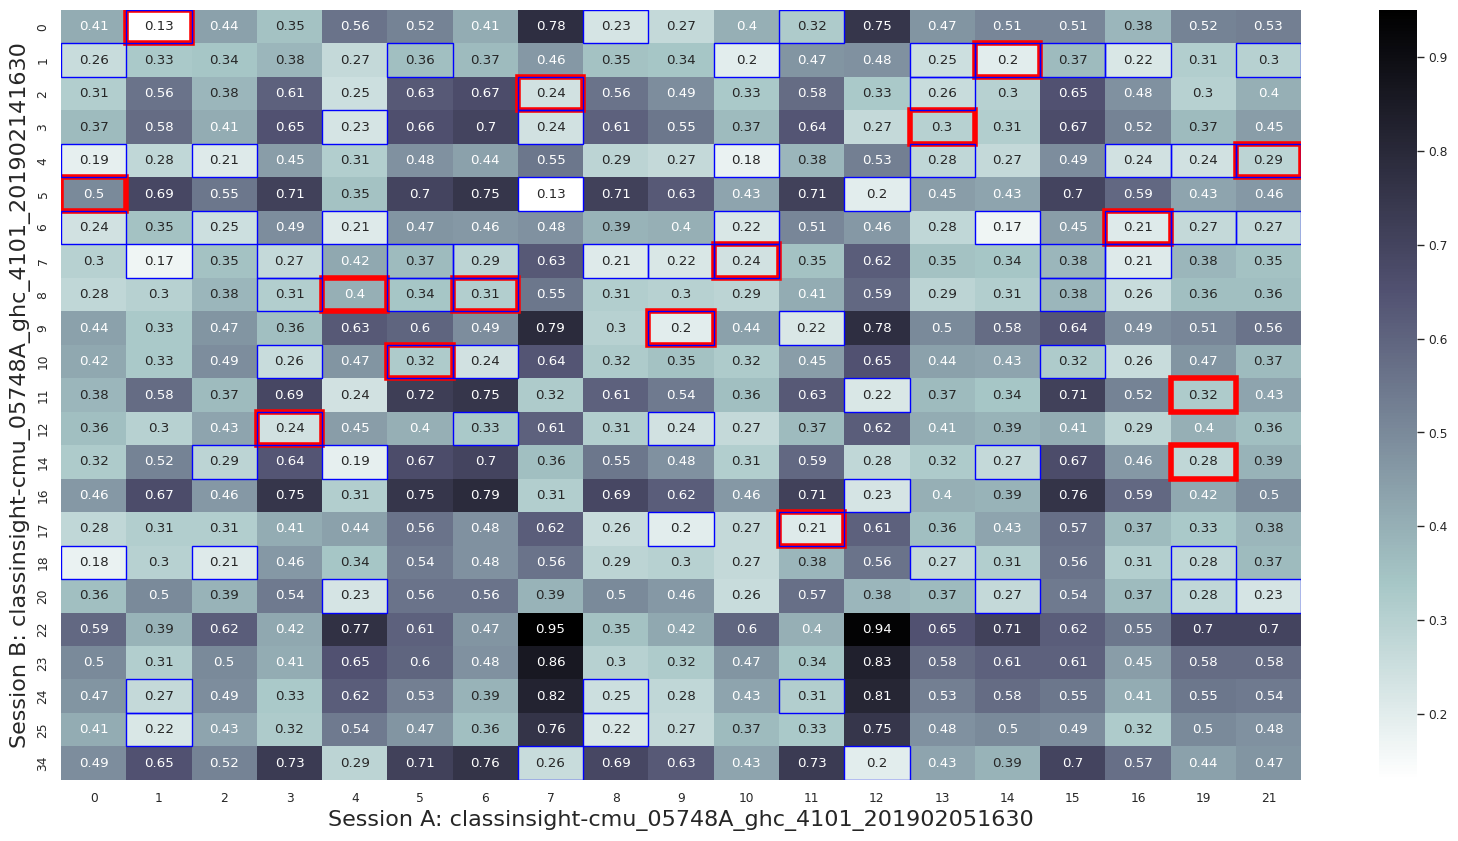

In [51]:
from matplotlib.patches import Rectangle
fig, axn = plt.subplots(1,1,figsize=(20,10))
sns.heatmap(df_matching_methodC.round(2), annot=True,ax=axn,cmap='bone_r')
for gtA in map(int, gt_map):
    for gtB in map(int, gt_map[str(gtA)]):
        if (gtA>=0) and (gtB>=0):
            if (gtA in df_matching_methodC.columns) and (gtB in df_matching_methodC.index):
                locA, locB = df_matching_methodC.columns.get_loc(gtA), df_matching_methodC.index.get_loc(gtB)
                axn.add_patch(Rectangle((locA, locB), 1, 1, fill=False, edgecolor='red', lw=4))

for locA in range(df_matching_methodC.shape[1]):
    locBs = df_matching_methodC.iloc[:,locA].argsort()[:4]
    for locB in locBs:
        axn.add_patch(Rectangle((locA, locB), 1, 1, fill=False, edgecolor='blue', lw=1))

# 4, 8, 10, 11 ...  
# absent: 5 out of 20 (how??)
# 

axn.set_xlabel(f"Session A: {sessionA}",fontsize=16)
axn.set_ylabel(f"Session B: {sessionB}",fontsize=16)
plt.savefig(f'plots/Method3_{course}_{sessionA.split("_")[-1]}_{sessionB.split("_")[-1]}.png',dpi=400,bbox_inches='tight')